In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from Classifications import Classifications

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks

In [3]:
seed = 42
rng = np.random.default_rng(seed=seed)
classifications = Classifications()

In [4]:
def display_rotation(rotation: R):
    rotated_vectors = rotation.apply(np.identity(3))
    print(f"Rotated coordinate vectors:\n{rotated_vectors}\n")
    print(f"Euler rotations:\n{rotation.as_euler('xyz', degrees=True)}")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    labels = ['Rotated x', 'Rotated y', 'Rotated z']
    for i in range(3):
        ax.plot(
            [0, rotated_vectors[i, 0]],
            [0, rotated_vectors[i, 1]],
            [0, rotated_vectors[i, 2]],
            color=colors[i], linewidth=1, label=labels[i]
        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    ax.set_zticks(np.arange(-1, 2, 1))
    ax.set_box_aspect([1, 1, 1])
    ax.set_title("Rotated Coordinate Axes")
    ax.legend()
    plt.show()

Rotated coordinate vectors:
[[-0.2544484   0.29665039  0.92046432]
 [-0.7800519   0.49964543 -0.37666096]
 [-0.57164241 -0.81385072  0.10426873]]

Euler rotations:
[-74.52664384 -66.99405642 130.62095523]


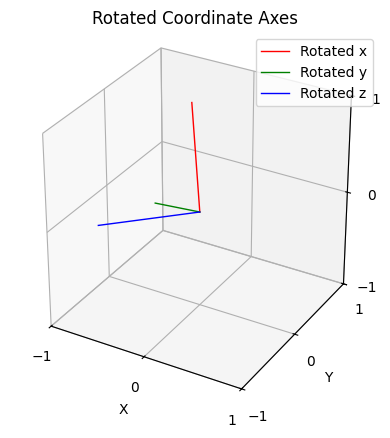

In [5]:
random_rotation = R.random(rng=rng)
display_rotation(random_rotation)

In [6]:
df = pd.read_csv("../sample_sensor_data.csv")

# Start at 0 milliseconds
df["ms"] -= df["ms"].min()

# Magnitudes
df["|a|"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
df["|g|"] = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)

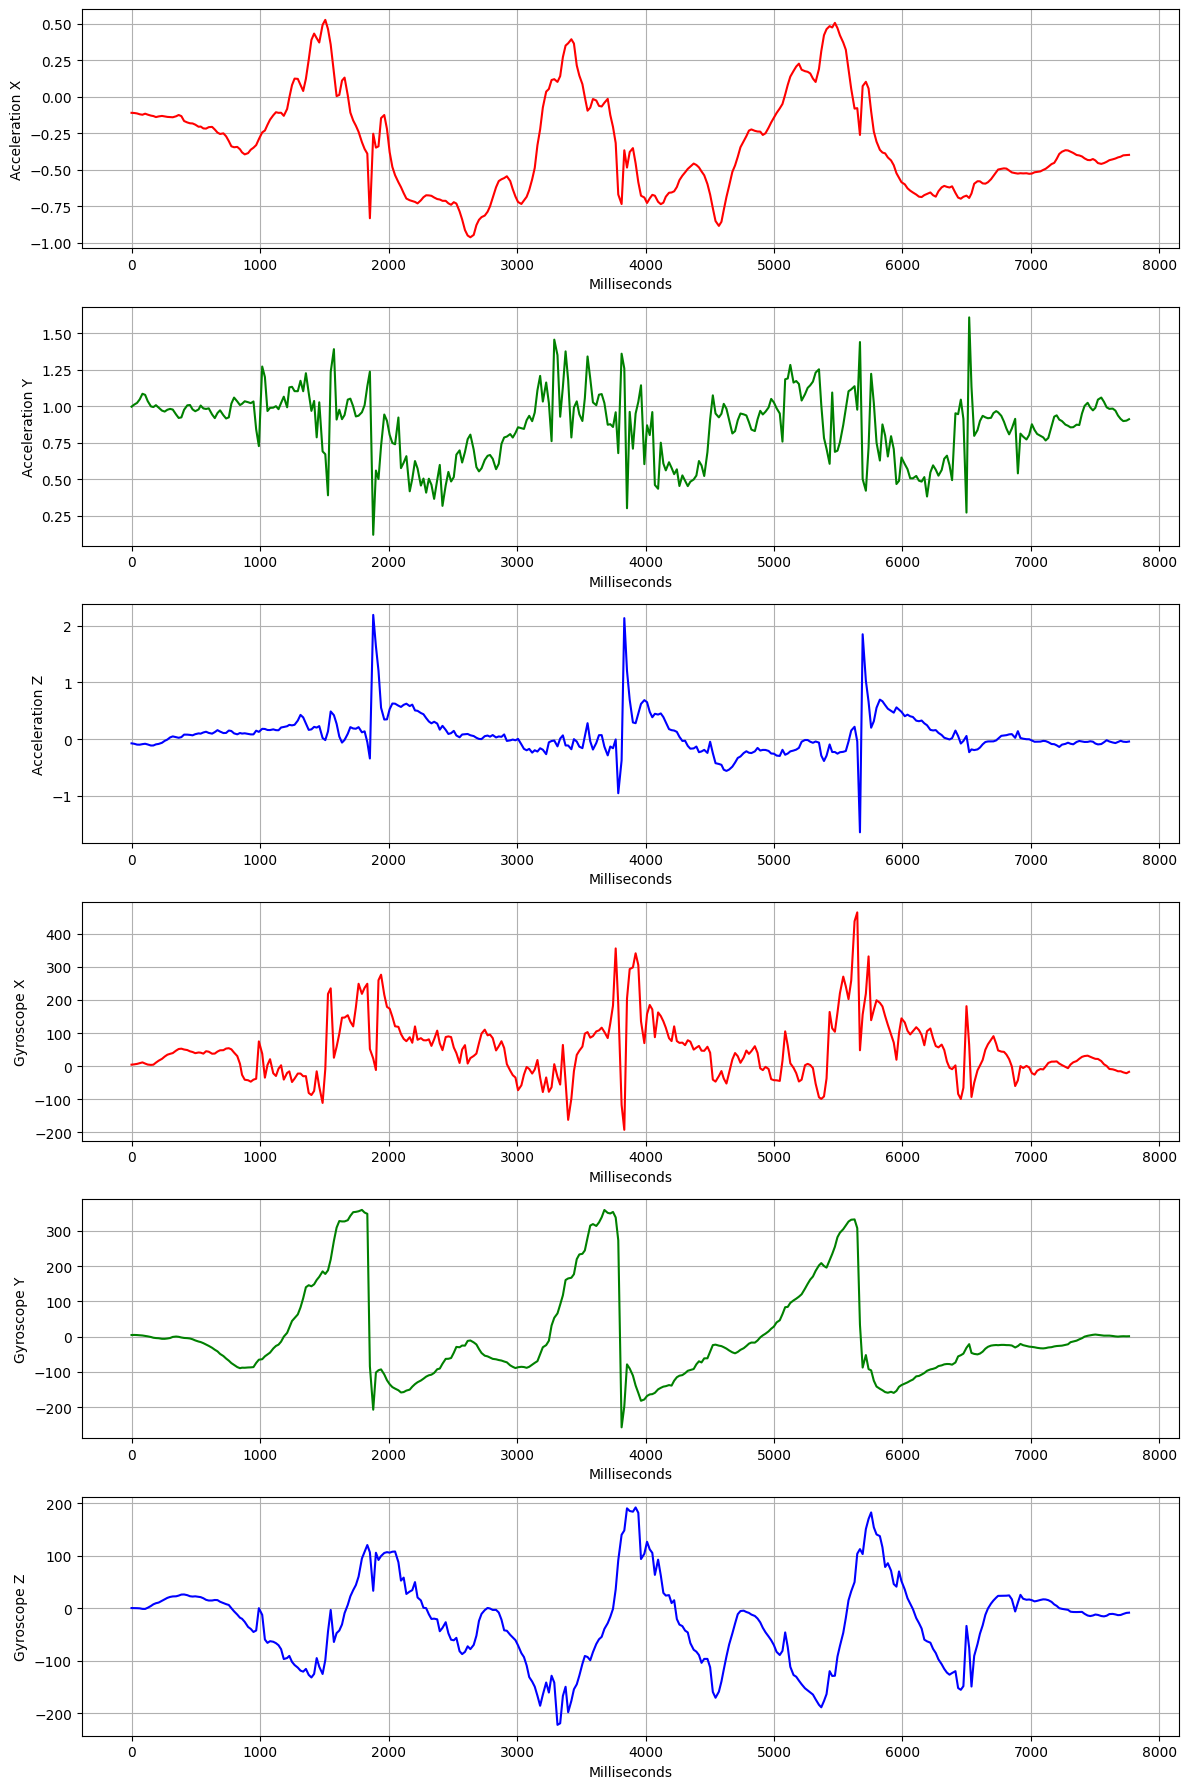

In [7]:
plots = (
    { "label": "ax", "title": "Acceleration X", "color": "r" },
    { "label": "ay", "title": "Acceleration Y", "color": "g" },
    { "label": "az", "title": "Acceleration Z", "color": "b" },
    { "label": "gx", "title": "Gyroscope X", "color": "r" },
    { "label": "gy", "title": "Gyroscope Y", "color": "g" },
    { "label": "gz", "title": "Gyroscope Z", "color": "b" },
)

fig, axes = plt.subplots(len(plots), 1, figsize=(12, 3 * len(plots)))
for ax, plot in zip(axes, plots):
    ax.plot(df["ms"], df[plot["label"]], label=plot["title"], color=plot["color"])
    ax.set_xlabel("Milliseconds")
    ax.set_ylabel(plot["title"])
    ax.grid(True)

plt.tight_layout()
plt.show()

[ 87 177 262]


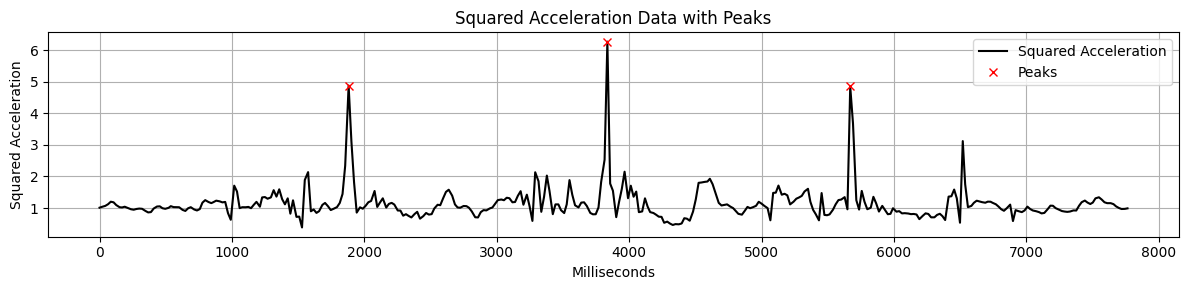

In [8]:
# Acceleration Squared (will be used on Arduino as threshold for shot detection)
squared_acceleration_data = np.sum(df[["ax", "ay", "az"]].values**2, axis=1)
peaks, _ = find_peaks(
    squared_acceleration_data,
    height=classifications.squared_acceleration_threshold,
    distance=classifications.num_shot_steps,
)
print(peaks)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df["ms"], squared_acceleration_data, label="Squared Acceleration", color="k")
ax.plot(df["ms"].iloc[peaks], squared_acceleration_data[peaks], "rx", label="Peaks")
ax.set_title("Squared Acceleration Data with Peaks")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Squared Acceleration")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

Rotated coordinate vectors:
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]

Euler rotations:
[180.   0.   0.]


Rotated coordinate vectors:
[[ 0.39058623  0.88996769 -0.23537187]
 [ 0.91874984 -0.36080416  0.16037173]
 [ 0.05780251 -0.27888685 -0.9585828 ]]

Euler rotations:
[170.50232691  13.61354399  66.3044413 ]


Rotated coordinate vectors:
[[-0.42529368  0.66308846  0.61598618]
 [-0.63587041  0.26540846 -0.72472559]
 [-0.64404512 -0.69990859  0.30876179]]

Euler rotations:
[-66.92407547 -38.02361323 122.6754228 ]


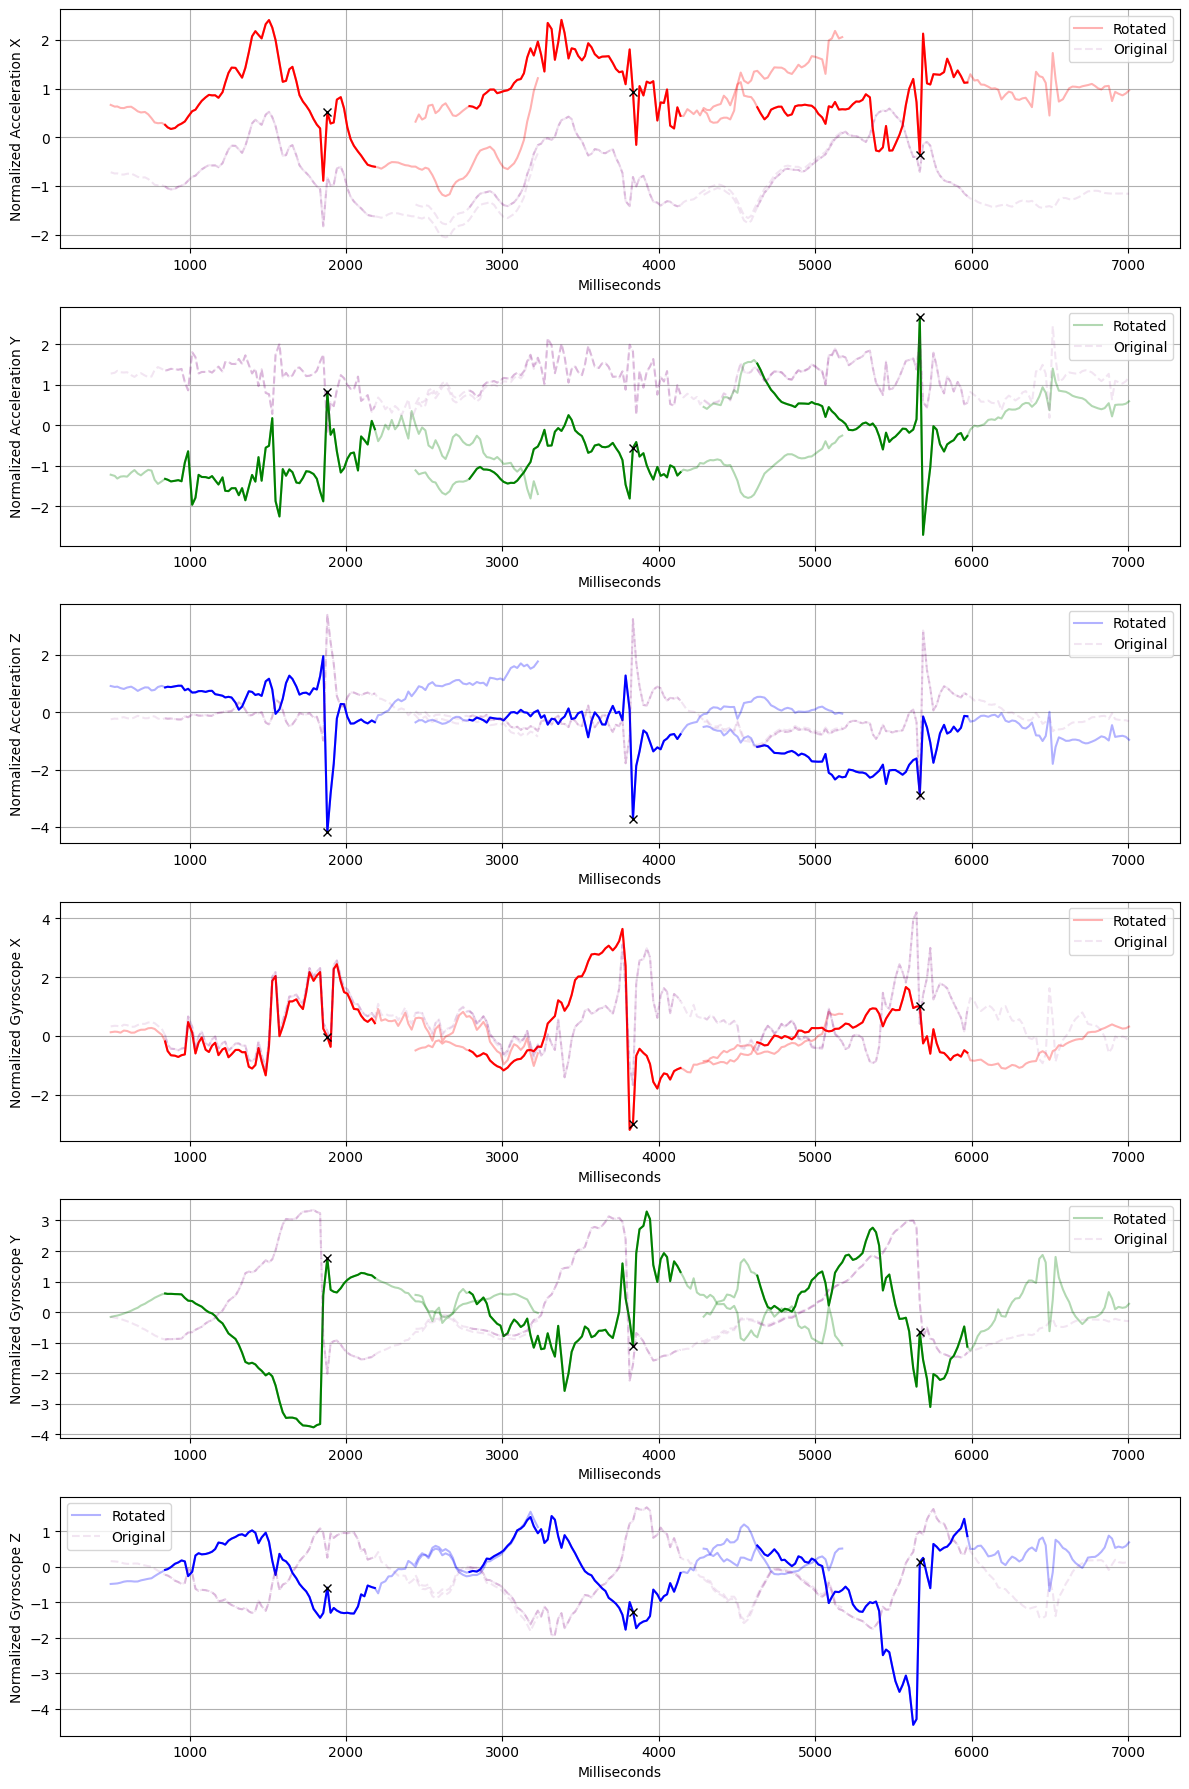

In [9]:
plots = (
    { "label": "ax'", "title": "Normalized Acceleration X", "color": "r" },
    { "label": "ay'", "title": "Normalized Acceleration Y", "color": "g" },
    { "label": "az'", "title": "Normalized Acceleration Z", "color": "b" },
    { "label": "gx'", "title": "Normalized Gyroscope X", "color": "r" },
    { "label": "gy'", "title": "Normalized Gyroscope Y", "color": "g" },
    { "label": "gz'", "title": "Normalized Gyroscope Z", "color": "b" },
)

labels = [d["label"] for d in plots]

# Plotting just the normalized detected shot data
fig, axes = plt.subplots(len(plots), 1, figsize=(12, 3 * len(plots)))

first = True
for peak in peaks:
    start_zscore_idx = max(0, peak - classifications.zscore_steps_before_peak)
    end_zscore_idx = peak + classifications.zscore_steps_after_peak

    zscore_data = df.iloc[start_zscore_idx:end_zscore_idx].copy()
    rotated_zscore_data = zscore_data.copy()

    # Random rotation for generalization
    if first:
        random_rotation = R.from_euler(seq="x", angles=180, degrees=True)
    else:
        random_rotation = R.random(rng=rng)
    rotated_vectors = random_rotation.apply(np.identity(3))
    if not first:
        print("\n")
    print(f"Rotated coordinate vectors:\n{rotated_vectors}\n")
    print(f"Euler rotations:\n{random_rotation.as_euler('xyz', degrees=True)}")

    rotated_zscore_data[["ax", "ay", "az"]] = random_rotation.apply(rotated_zscore_data[["ax", "ay", "az"]].to_numpy(), random_rotation)
    rotated_zscore_data[["gx", "gy", "gz"]] = random_rotation.apply(rotated_zscore_data[["gx", "gy", "gz"]].to_numpy(), random_rotation)

    # z-score norm
    zscore_data[["ax'", "ay'", "az'"]] = (zscore_data[["ax", "ay", "az"]] - zscore_data[["ax", "ay", "az"]].mean(axis=None)) / zscore_data[["ax", "ay", "az"]].to_numpy().std()
    zscore_data[["gx'", "gy'", "gz'"]] = (zscore_data[["gx", "gy", "gz"]] - zscore_data[["gx", "gy", "gz"]].mean(axis=None)) / zscore_data[["gx", "gy", "gz"]].to_numpy().std()
    rotated_zscore_data[["ax'", "ay'", "az'"]] = (rotated_zscore_data[["ax", "ay", "az"]] - rotated_zscore_data[["ax", "ay", "az"]].mean(axis=None)) / rotated_zscore_data[["ax", "ay", "az"]].to_numpy().std()
    rotated_zscore_data[["gx'", "gy'", "gz'"]] = (rotated_zscore_data[["gx", "gy", "gz"]] - rotated_zscore_data[["gx", "gy", "gz"]].mean(axis=None)) / rotated_zscore_data[["gx", "gy", "gz"]].to_numpy().std()

    # Adjust shot indexes to zscore data slice
    start_shot_idx = max(0, peak - classifications.shot_steps_before_peak - start_zscore_idx)
    end_shot_idx = peak + classifications.shot_steps_after_peak - end_zscore_idx

    for ax, plot in zip(axes, plots):
        ax.plot(rotated_zscore_data["ms"], rotated_zscore_data[plot["label"]], label="Rotated", color=plot["color"], alpha=0.3)
        ax.plot(zscore_data["ms"], zscore_data[plot["label"]], label="Original", color="purple", linestyle="--", alpha=0.1)

        rotated_shot_data = rotated_zscore_data.iloc[start_shot_idx:end_shot_idx]
        shot_data = zscore_data.iloc[start_shot_idx:end_shot_idx]

        ax.plot(rotated_shot_data["ms"], rotated_shot_data[plot["label"]], color=plot["color"], alpha=1)
        ax.plot(shot_data["ms"], shot_data[plot["label"]], color="purple", linestyle="--", alpha=0.2)

        ax.plot(rotated_shot_data["ms"].iloc[classifications.shot_steps_before_peak], rotated_shot_data[plot["label"]].iloc[classifications.shot_steps_before_peak], "kx")

        ax.set_xlabel("Milliseconds")
        ax.set_ylabel(plot["title"])
        if first:
            ax.legend()
        ax.grid(True)
    first = False

plt.tight_layout()
plt.show()